

# Import Packages

In [ ]:
!pip install matplotlib.pyplot # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
!pip install keras  # https://keras.io/
!pip install sklearn # https://scikit-learn.org/

import xgboost
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import numpy as np
from os.path import join as pjoin 

# SkLearn Models
from sklearn.naive_bayes import BernoulliNB,  MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection as fs
from sklearn.linear_model import LinearRegression

# Neural Network
import tensorflow as tf
import numpy as np
import random
import os
import pickle

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, CSVLogger, History
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy & core Python generated random numbers
# in a well-defined initial state. (inspired by: https://github.com/t-davidson/fragile-families-challenge )
np.random.seed(42)
random.seed(54321)

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Imputation & Preprocessing

In [ ]:
def fillMissing(inputcsv, outputcsv):    
  df = pd.read_csv(inputcsv, low_memory=False)    
  # Fix date bug    
  df.cf4fint = ((pd.to_datetime(df.cf4fint) - pd.to_datetime('1960-01-01')) / np.timedelta64(1, 'D')).astype(int)     
  df.to_csv(outputcsv, index=False)

  # replacing with mode has been moved to a later section as other imputations come first


In [ ]:
  # Given in assignment
  # Usage:if __name__ == "__main__":       
  data_dir = "."   
  # impute the background data    
  in_path = pjoin(data_dir,  r"background.csv")    
  out_path = pjoin(data_dir, r"background_clean.csv")    
  fillMissing(in_path, out_path)

In [ ]:
# read in csb files
train = r"train.csv"
train_df = pd.read_csv(train)
background = r"background_clean.csv"
background_df = pd.read_csv(background)
prediction = r"prediction.csv"

# Keep different dataframes for different models
prediction_df = pd.read_csv(prediction)
prediction_df2 = pd.read_csv(prediction)
prediction_df3 = pd.read_csv(prediction)
prediction_df4 = pd.read_csv(prediction)
prediction_df5 = pd.read_csv(prediction)
prediction_df6 = pd.read_csv(prediction)
prediction_df7 = pd.read_csv(prediction)
prediction_df8 = pd.read_csv(prediction)

In [ ]:
# Remove columns with non-number values, as difficult to quantify adequately
#source: https://stackoverflow.com/questions/42335385/delete-every-column-that-contains-a-string-in-dataframe
background_df = background_df[background_df.T[background_df.dtypes!=np.object].index]


In [ ]:
# Replace all missing values (negatives)  with NaN, given past reasearchers experience on this specific dataset
# source: https://github.com/t-davidson/fragile-families-challenge/blob/master/preprocess/clean_files.py
background_df.index = background_df.challengeID
train_df.index = train_df.challengeID
del background_df['challengeID']
del train_df['challengeID']
outcomes = list(train_df.columns)

# Merging background and outcomes so that missing obs can be imputed
background_df = pd.concat([background_df, train_df], axis=1, join='outer')

# Replace missing codes with NaN
background_df = background_df.replace({-1: np.NaN, -2: np.NaN, -3: np.NaN,
                 -4: np.NaN, -5: np.NaN, -6: np.NaN,
                 -7: np.NaN, -8: np.NaN, -9: np.NaN, np.inf: np.NaN,
                 -np.inf: np.NaN})


In [ ]:
# Identifying columns with high missingness
# source: https://github.com/t-davidson/fragile-families-challenge/blob/master/preprocess/clean_files.py

threshold = 0.85 # different threshholds were tested
high_missingness = 0
columns_to_use = []
for c in background_df.columns:
    if c not in outcomes:
        missing_prop = (background_df[c].isnull().sum() / background_df.shape[0])
        if missing_prop > threshold:
            high_missingness += 1
        else:
            columns_to_use.append(c)
    else:  # if it is an outcome column then always keep it
        columns_to_use.append(c)

print(str(high_missingness), " columns with over ",
      str(threshold * 100), " percent missing")

background_df = background_df[columns_to_use]

7227  columns with over  85.0  percent missing


In [ ]:
#make a copy
background_copy=background_df.copy()

#drop rows with NAs in outcomes
background_df = background_df.dropna(subset=['gpa', 'eviction', 'layoff', 'grit', 'materialHardship', 'jobTraining']) 

# fill NAs of background
background_df = background_df.fillna(background_df.mode().iloc[0])    
# if still NA, replace with 1    
background_df = background_df.fillna(value=1)    
# replace negative values with 1    
num = background_df._get_numeric_data()    
num[num < 0] = 1 
num[num == np.inf] = 1 


#fill NAs of background copy
background_copy = background_copy.fillna(background_copy.mode().iloc[0])    
# if still NA, replace with 1    
background_copy = background_copy.fillna(value=1)    
# replace negative values with 1    
num = background_copy._get_numeric_data()    
num[num < 0] = 1 
num[num == np.inf] = 1 



In [ ]:
# Remove columns with < 0.1 variance
bg = background_df.loc[:, 'cf1lenhr':'k5f1']
background_copy=background_copy.loc[:, 'cf1lenhr':'k5f1']

# Finding columns with zero variance and removing them 
vt = fs.VarianceThreshold(0.1)
vfs = vt.fit(bg)
vfs1 = vt.fit(background_copy)
bg = bg.loc[:, vfs.get_support()]
background_copy = background_copy.loc[:, vfs1.get_support()]

# Get outcomes df
train = background_df.loc[:, 'gpa':'jobTraining']
train=train.astype('float')

# Models

In [ ]:
categorical = ['eviction', 'layoff', 'jobTraining']
cont = ['gpa', 'grit', 'materialHardship']

In [ ]:
# Initial Basemodel - Not used in paper and thus commented out
'''
for label in cont:
  linear = LinearRegression()
  linear.fit(bg, train[label])
  prediction_df[label] = linear.predict(background_copy)


for label in categorical:
  bnb = BernoulliNB()
  bnb.fit(bg, train[label])
  prediction_df[label] = bnb.predict(background_copy)
'''

In [ ]:
prediction_df.to_csv(r"prediction.csv", index=False)

## Neural Network

In [ ]:
# The code in this section is adapted from T. Davidson's neural network: https://github.com/t-davidson/fragile-families-challenge/blob/master/preprocess/clean_files.py
def make_model(activation_function, num_hidden_layers, hidden_layer_size): 
  model = Sequential()

    # Single layer model
  if num_hidden_layers == 0: # then just specify a single layer, 1 is size of output
        model.add(Dense(1, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        model.add(Dropout(0.5))
    
    # Specify initial layer with a hidden layer
  if num_hidden_layers >= 1: 
        model.add(Dense(hidden_layer_size, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        model.add(Dropout(0.5))
    
    # Now add additional hidden layers
  for i in range(0,num_hidden_layers-1):
        model.add(Dense(hidden_layer_size, 
                        activation=activation_function, 
                        use_bias=True))
        model.add(Dropout(0.5))
    
  if num_hidden_layers > 0:       
        model.add(Dense(1)) # Final output layer, don't add if no hidden layers

  model.compile(loss='mean_squared_error',
                  optimizer='adam')
  return model

In [ ]:
# Set to 100 epochs and set parameters
classifier = KerasRegressor(make_model, batch_size=32, epochs=100)

params = [{'num_hidden_layers': [0],
          'hidden_layer_size': [0],
          'activation_function': ['linear', 'sigmoid', 'tanh']},
          {'num_hidden_layers': [1,2,3],
          'hidden_layer_size': [64, 128, 256],
          'activation_function': ['linear', 'sigmoid', 'tanh']}]

In [ ]:
# Run gridsearch
for label in train_df.columns:
  X_train, X_test, y_train, y_test = train_test_split(bg, train[label], test_size=0.20, random_state=12345)
  grid = GridSearchCV(classifier,
                         param_grid=params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5,# Number of folds for CV
                     
                   )
  grid.fit(np.array(X_train), np.array(y_train))
  print('The parameters of the best model are: ')
  print(grid.best_params_)
  print(grid.best_estimator_)
  best_model = grid.best_estimator_ #scikit-wrapped best model
  prediction_df2[label] = best_model.predict(background_copy)

prediction_df.to_csv(r"prediction.csv", index=False)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Epoch 1/100
21/21 [==============================] - 0s 560us/step - loss: 177858823.2727
Epoch 2/100
21/21 [==============================] - 0s 521us/step - loss: 21134383.2727
Epoch 3/100
21/21 [==============================] - 0s 499us/step - loss: 20200592.8182
Epoch 4/100
21/21 [==============================] - 0s 520us/step - loss: 12996882.7727
Epoch 5/100
21/21 [==============================] - 0s 525us/step - loss: 10356027.2500
Epoch 6/100
21/21 [==============================] - 0s 499us/step - loss: 7821907.4545
Epoch 7/100
21/21 [==============================] - 0s 484us/step - loss: 6477117.5909
Epoch 8/100
21/21 [==============================] - 0s 486us/step - loss: 4240603.0568
Epoch 9/100
21/21 [==============================] - 0s 487us/step - loss: 5173806.3295
Epoch 10/100
21/21 [==============================] - 0s 484us/step - loss: 3643814.8977
Epoch 11/100
21/21 [==============================]

In [ ]:
# Round categorical predictions
for label in categorical:
  prediction_df2[label] = prediction_df2[label].round()

In [ ]:
# Save in csv
prediction_df2.to_csv(r"predictionNeural.csv", index=False)

## Random Forest

In [ ]:
parameters = {'criterion':('gini','entropy')}
for label in categorical:
  rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)
  X_train, X_test, y_train, y_test = train_test_split(bg, train[label], test_size=0.20, random_state=12345)
  rf.fit(X_train, y_train)
  prediction_df3[label] = rf.predict(background_copy)


In [ ]:
prediction_df3.to_csv(r"predictionRf.csv", index=False)

## Lasso

In [ ]:
#Adapted from: https://alfurka.github.io/2018-11-18-grid-search/
from sklearn import linear_model
classifier = linear_model.Lasso()

# Other alphas were tested too.
# only converges larger alpha (>0.5)
# Best: alpha = 1 for all
# NOTE: Might not always converge.
params = {'alpha':[0.7, 0.8, 0.9, 1]}
for label in cont:
  X_train, X_test, y_train, y_test = train_test_split(bg, train[label], test_size=0.20, random_state=12345)
  lasso = GridSearchCV(classifier, params)
  lasso.fit(bg, train[label])
  estimator = lasso.best_estimator_
  # print(estimator)
  prediction_df4[label] = estimator.predict(background_copy)

/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056567879111042885, tolerance: 0.034121038840937125
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)
Lasso(alpha=1)
Lasso(alpha=1)


In [ ]:
prediction_df4.to_csv(r"predictionLasso.csv", index=False)

## Baseline Model

In [ ]:
# Run GridSearch on Linear Regression
linreg = LinearRegression(normalize = False)
lin_params = [{'fit_intercept': [True, False], 'normalize': [True, False]}]

for label in cont:
  gridLin = GridSearchCV(linreg,
                         param_grid=lin_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5)

gridLin.fit(bg, train[label])
prediction_df5[label] = gridLin.predict(background_copy)
prediction_df5[prediction_df5<0]=0
prediction_df5.to_csv(r"predictionBase.csv", index=False)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................fit_intercept=True, normalize=True; total time=   0.3s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.4s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.3s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.3s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.3s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.3s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.3s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.3s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.3s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.3s
[CV] END ................fit_intercept=False, normalize=True; total time=   0.3s
[CV] END ................fit_intercept=False, nor

NameError: name 'prediction_df5' is not defined

In [ ]:
# Run Gridsearch on Logarithmic Regression
# Different Parameters tested, but commented out after for  computational speed
logreg = LogisticRegression(max_iter=200)
log_params = [{'penalty':['elasticnet','l1', 'l2','none'], 
               #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'solver': ['saga', 'sag'],
               'fit_intercept': [True]
               #'fit_intercept': [True, False]
              }]

for label in categorical:
  gridLog = GridSearchCV(logreg,
                         param_grid=log_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=2)
  gridLog.fit(bg, train[label])
  print(gridLog.best_params_)
  prediction_df6[label] = gridLog.predict(background_copy)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):


[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.3s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports o

[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.3s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.06706114         nan -0.06706114 -0.07001972
 -0.06706114 -0.07001972]
  warnings.warn(


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/asursock/.local/lib/python3.8

{'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports o

[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.4s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.22879684         nan -0.22978304 -0.22287968
 -0.23076923 -0.22287968]
  warnings.warn(


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1314, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/asursock/.local/lib/python3.8

{'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END fit_intercept=True, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .fit_intercept=True, penalty=elasticnet, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.3s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports o

[CV] END ........fit_intercept=True, penalty=l1, solver=saga; total time=   4.2s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s
[CV] END .........fit_intercept=True, penalty=l1, solver=sag; total time=   0.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ........fit_intercept=True, penalty=l2, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .........fit_intercept=True, penalty=l2, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END ......fit_intercept=True, penalty=none, solver=saga; total time=   3.0s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/asursock/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.29684418         nan -0.29684418 -0.29191321
 -0.29783037 -0.29289941]
  warnings.warn(


[CV] END .......fit_intercept=True, penalty=none, solver=sag; total time=   2.4s
{'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag'}


/home/asursock/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [ ]:
# Interesting Side-Project: Special Baseline Model for GPA  only - using solely 3 features to predict gpa
background_df.head()
gpaBase = background_df[['m1h3', 'm1h3a', 'cm1edu']]
#'t5c13a', 't5c13b', 't5c13c'
gpaBaseCopy = background_copy[['m1h3', 'm1h3a', 'cm1edu']]

bg_train, bg_test, y_train, y_test = train_test_split(gpaBase, train['gpa'], test_size=0.20, random_state=12345)

baseline1 = LinearRegression(normalize = False) # Features already standardized so normalize is False
baseline1_params = params = [{'fit_intercept': [True, False] }]
grid = GridSearchCV(baseline1,
                         param_grid=baseline1_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5)

grid.fit(bg_train, y_train)
prediction_df['gpa'] = grid.predict(gpaBaseCopy)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] fit_intercept=True ..............................................
[CV] ............................... fit_intercept=True, total=   0.0s
[CV] fit_intercept=True ..............................................
[CV] ............................... fit_intercept=True, total=   0.0s
[CV] fit_intercept=True ..............................................
[CV] ............................... fit_intercept=True, total=   0.0s
[CV] fit_intercept=True ..............................................
[CV] ............................... fit_intercept=True, total=   0.0s
[CV] fit_intercept=True ..............................................
[CV] ............................... fit_intercept=True, total=   0.0s
[CV] fit_intercept=False .............................................
[CV] .............................. fit_intercept=False, total=   0.0s
[CV] fit_intercept=False .............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
prediction_df6[prediction_df6<0]=0
prediction_df6.to_csv(r"predictionBaseLinCat.csv", index=False) # categorical only
print(mean_squared_error(y_test, grid.predict(np.array(bg_test))))
preds = grid.predict(np.array(gpaBaseCopy))
predictionsBase = prediction_df.copy()
predictionsBase['gpa'] = preds
predictionsBase.to_csv('baseline_predictions.csv')

0.39708179278784583


## Gradient Boosted Classifier

In [ ]:
# Predict Categorical
from sklearn.ensemble import GradientBoostingClassifier 
classifier = GradientBoostingClassifier()
params = [{'n_estimators':[100], 'loss':['deviance', 'exponential']}]

for label in categorical:
  gbGS = GridSearchCV(classifier, params)
  gbGS.fit(bg, train[label])
  estimator = gbGS.best_estimator_
  print(estimator)
  prediction_df7[label] = estimator.predict(background_copy)

prediction_df7[prediction_df7<0]=0

TypeError: string indices must be integers

In [ ]:
# Predict Continuous
from sklearn.ensemble import GradientBoostingRegressor 
classifier = GradientBoostingRegressor()
params = [{'n_estimators':[100,200], 'loss':['ls', 'lad', 'huber', 
                                                 'quantile'], 
           'learning_rate':[0.5, 1]}]

for label in cont:
  gbGSR = GridSearchCV(classifier, params)
  gbGSR.fit(bg, train[label])
  estimator = gbGSR.best_estimator_
  print(estimator)
  prediction_df[label] = estimator.predict(background_copy)

In [ ]:
# Predict Continuous but no GridSearch - added for convenience & time purposes
from sklearn.ensemble import GradientBoostingRegressor 
for label in cont:
  GB = GradientBoostingRegressor()
  GB.fit(bg, train[label])
  prediction_df8[label] = GB.predict(background_copy)

In [ ]:
# Predict Categorical but no GridSearch - added for convenience & time purposes
from sklearn.ensemble import GradientBoostingClassifier
prediction_df9 = pd.read_csv(prediction)
for label in categorical:
  GB = GradientBoostingClassifier(random_state=0)
  GB.fit(bg, train[label])
  prediction_df9[label] = GB.predict(background_copy)

## Ensemble Classifier

In [ ]:
# pred4 = Lasso // pred2 = Neural // pred5 = linReg // pred6 = log // pred11 = XGBoost
ensemble = pd.read_csv(prediction) 
for col in cont :
    i = 0
    while i < ensemble[col].size - 1:
        i += 1
        ensemble[col][i] = (prediction_df11[col][i] + prediction_df4[col][i] + prediction_df2[col][i] + prediction_df5[col][i])/4
        
for col in categorical:
    i = 0
    while i < ensemble[col].size - 1:
        i += 1
        score = (prediction_df6[col][i] + prediction_df2[col][i] +prediction_df9[col][i])/3
        score = score.round()
        ensemble[col][i] = score

NameError: name 'prediction_df5' is not defined

In [ ]:
ensemble.to_csv(r"prediction.csv", index=False)

## XGBoosting  Regressor & Classifier

In [ ]:
# Train XGBClassifier on Categoricals using GridSearch
# NOTE: Computationally HEAVY
from xgboost import XGBClassifier
prediction_df10 = pd.read_csv(prediction)
classifier = XGBClassifier()
params = [{'n_estimators':[100,200,500]}]
for label in categorical:
  gbGSX = GridSearchCV(classifier, params)
  gbGSX.fit(bg, train[label])
  estimator = gbGSX.best_estimator_
  print(estimator)
  prediction_df10[label] = estimator.predict(background_copy)

In [ ]:
# Train XGBRegressor on Continuous using GridSearch
# NOTE: Computationally HEAVY
from xgboost import XGBRegressor
prediction_df11 = pd.read_csv(prediction)

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.05, .07, .1], #so called `eta` value
              'max_depth': [5,6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

# Gridsearch
for label in cont:
  xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)
  xgb_grid.fit(bg, train[label])
  estimator = xgb_grid.best_estimator_
  print(estimator)
  prediction_df11[label] = estimator.predict(background_copy)

prediction_df11.to_csv(r"prediction.csv", index=False)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[21:58:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:58:14] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=

# Racial Bias & Residual Analysis

In [ ]:
# We did this ourselves and are proud of it.
def racialBiasCalc(xtest, xtestEth, ytest, ypred):
    hisp = [0,0,0,0,0]
    white = [0,0,0,0,0]
    black = [0,0,0,0,0]
    asian = [0,0,0,0,0]
    amind = [0,0,0,0,0]

    # Loop through validation set and see residual errors based on race and ethnicity
    index = -1
    for none in xtest:
        index += 1
        num = xtest[index]
        if xtestEth[index] == 1:
            hisp[0] += 1
            hisp[1] += ytest[index] - ypred[index]
            hisp[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
            hisp[3] += ypred[index]
            hisp[4] += ytest[index]
            
        else:
            if num == 1:
                white[0] += 1
                white[1] += ytest[index] - ypred[index]
                white[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
                white[3] += ypred[index]
                white[4] += ytest[index]
            if num == 2:
                black[0] += 1
                black[1] += ytest[index] - ypred[index]
                black[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
                black[3] += ypred[index]
                black[4] += ytest[index]
            if num == 3:
                asian[0] += 1
                asian[1] += ytest[index] - ypred[index]
                asian[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
                asian[3] += ypred[index]
                asian[4] += ytest[index]
            if num == 4:
                amind[0] += 1
                amind[1] += ytest[index] - ypred[index]
                amind[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
                amind[3] += ypred[index]
                amind[4] += ytest[index]
            
    print(" ")     
    print("Order: 0. Hisp // 1. White // 2. Black // 3. Asian // 4. AmInd")
    print(" ")
    print("Average signed error")
    print(hisp[1]/hisp[0])
    print(white[1]/white[0])
    print(black[1]/black[0])
    print(asian[1]/asian[0])
    if amind[0] != 0:
        print(amind[1]/amind[0])


    print(" ")
    print("Average squared error")
    print(hisp[2]/hisp[0])
    print(white[2]/white[0])
    print(black[2]/black[0])
    print(asian[2]/asian[0])
    if amind[0] != 0:
        print(amind[2]/amind[0])

    print(" ")
    print("Average Prediction")
    print(hisp[3]/hisp[0])
    print(white[3]/white[0])
    print(black[3]/black[0])
    print(asian[3]/asian[0])
    if amind[0] != 0:
        print(amind[3]/amind[0])

    print(" ")
    print("Average in validation set")
    print(hisp[4]/hisp[0])
    print(white[4]/white[0])
    print(black[4]/black[0])
    print(asian[4]/asian[0])
    if amind[0] != 0:
        print(amind[4]/amind[0])


In [ ]:
# Same but solely for ethnicity
def ethnBiasCalc(xtest, ytest, ypred):
    hisp = [0,0,0,0,0]
    nonHisp = [0,0,0,0,0]

    index = -1
    for none in xtest:
        index += 1
        num = xtest[index]
        if num == 1:
            hisp[0] += 1
            hisp[1] += ytest[index] - ypred[index]
            hisp[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
            hisp[3] += ypred[index]
            hisp[4] += ytest[index]
        if num == 2:
            nonHisp[0] += 1
            nonHisp[1] += ytest[index] - ypred[index]
            nonHisp[2] += (ytest[index] - ypred[index])*(ytest[index] - ypred[index])
            nonHisp[3] += ypred[index]
            nonHisp[4] += ytest[index]
            
    
    print(" ")     
    print("Order: 1. Hispanic // 2. Nonhispanic")
    print(" ")
    print("Average signed error")
    print(hisp[1]/hisp[0])
    print(nonHisp[1]/nonHisp[0])


    print(" ")
    print("Average squared error")
    print(hisp[2]/hisp[0])
    print(nonHisp[2]/nonHisp[0])


    print(" ")
    print("Average Prediction")
    print(hisp[3]/hisp[0])
    print(nonHisp[3]/nonHisp[0])


    print(" ")
    print("Average in validation set")
    print(hisp[4]/hisp[0])
    print(nonHisp[4]/nonHisp[0])



In [3]:
# We did this ourselves and are proud of it.
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(bg, train, test_size=0.2, random_state=1234)

# Train Model
gdp = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

gdp.fit(X_train, y_train['gpa'])
xtest = np.array(X_test['f1h3'])
xtestEth = np.array(X_test['f1h3a'])
ytest = np.array(y_test['gpa'])
ypred = prediction_df['gpa'].copy()
ypred = gdp.predict(X_test)

# Print Findings (Avg Signed Difference, Squared Residuals, Avg Prediction, and Actual Avg)
print('----GPA----')
racialBiasCalc(xtest, xtestEth, ytest, ypred) # for Racial and Ethnic features
ethnBiasCalc(xtestEth, ytest, ypred)      # for ethnicit only (Hispanic and Non-Hispanic)




# Same but optimized for Grit
grit = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

grit.fit(X_train, y_train['grit'])
xtest = np.array(X_test['f1h3'])
ytest = np.array(y_test['grit'])
ypred = prediction_df['grit'].copy()
ypred = grit.predict(X_test)

print('----GRIT----')
racialBiasCalc(xtest, xtestEth, ytest, ypred)


# Same but optimized for Material Hardship
hard = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

hard.fit(X_train, y_train['materialHardship'])
xtest = np.array(X_test['f1h3'])
ytest = np.array(y_test['materialHardship'])
ypred = prediction_df['materialHardship'].copy()
ypred = hard.predict(X_test)

print('----MATERIAL HARDSHIP----')
racialBiasCalc(xtest, xtestEth, ytest, ypred)

NameError: ignored

# Feature Importances & Selection Analysis

GPA


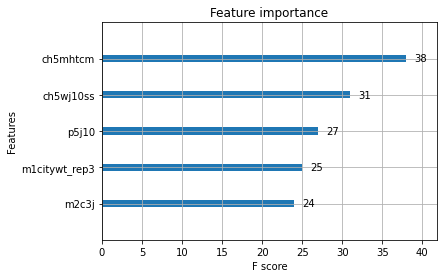

Grit


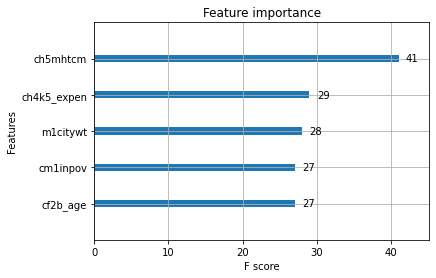

Material Hardship


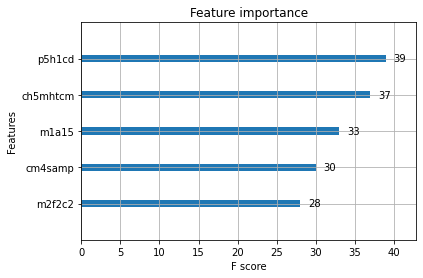

In [ ]:
print("GPA")
xgboost.plot_importance(gdp, max_num_features=5)
plt.show()

print("Grit")
xgboost.plot_importance(grit, max_num_features=5)
plt.show()

print("Material Hardship")
xgboost.plot_importance(hard, max_num_features=5)
plt.show()

In [ ]:
# Using most important features for each outcome, see if baseline model with only 5 features is accurate
prediction_df12 = pd.read_csv(prediction)

gpaFeatures = bg[['ch5wj10ss', 'ch5wj9ss', 'm1f1a', 'ch5bmip', 'cf1hhinc']].copy()
gritFeatures = bg[['cm2hhinc', 'p5j7','ch5mhtcm', 'p5j10', 'cf1lenmin']].copy()
hardFeatures = bg[['ch5mhtcm', 'p5j7', 'm1e1d1', 'cm4hhinc', 'm2b5c1']].copy()

gpaCopy = background_copy[['ch5wj10ss', 'ch5wj9ss', 'm1f1a', 'ch5bmip', 'cf1hhinc']].copy()
gritCopy = background_copy[['cm2hhinc', 'p5j7','ch5mhtcm', 'p5j10', 'cf1lenmin']].copy()
hardCopy = background_copy[['ch5mhtcm', 'p5j7', 'm1e1d1', 'cm4hhinc', 'm2b5c1']].copy()

gridLin[0].fit(gpaFeatures, train['gpa'])  
prediction_df12['gpa'] = gridLin[0].predict(gpaCopy)

gridLin[1].fit(gritFeatures, train['grit'])  
prediction_df12['grit'] = gridLin[1].predict(gritCopy)

gridLin[2].fit(hardFeatures, train['materialHardship'])  
prediction_df12['materialHardship'] = gridLin[2].predict(hardCopy)

prediction_df12.to_csv(r"prediction.csv", index=False)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END .................fit_intercept=True, normalize=True; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=True, normalize=False; total time=   0.0s
[CV] END ................fit_intercept=False, normalize=True; total time=   0.0s
[CV] END ................fit_intercept=False, nor

# Moonshots and Overachievers

In [ ]:
# Identifies children that outperform our model and then analyzes them based on
# select features, which can be set below.
X_train, X_test, y_train, y_test = train_test_split(bg, train, test_size=0.5, random_state=1234)

gdp = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)


gdp.fit(X_train, y_train['gpa'])
ytest = np.array(y_test['gpa'])
xtest = np.array(X_test['f1h3'])
ypred = prediction_df['gpa'].copy()
ypred = gdp.predict(X_test)

# Choose the features you are interested in finding out about moonshot children
xtestEth = np.array(X_test['f1h3a'])
xtest9 = np.array(X_test['ch5wj9ss'])
xtest10 = np.array(X_test['ch5wj10ss'])

moonshots(ypred, ytest, xtest, xtestEth, xtest9, xtest10)

Race:
1.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
1.0
Race:
5.0
Race:
2.0
Race:
4.0
Race:
2.0
Race:
2.0
Race:
5.0
Race:
2.0
Race:
1.0
Race:
5.0
Race:
2.0
Race:
5.0
Race:
1.0
Race:
5.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
2.0
Race:
2.0
---MOONSHOT COUNT---
26


In [ ]:
# Please adapt code given the features you are interested in of moonshot children
def moonshots(ypred, ytest, xtest, xtestEth, xtest9, xtest10):
    index = -1
    count = 0
    moonshots = [] 
    
    for none in xtest:
        index += 1
        num = xtest[index]
        if (ytest[index] - ypred[index]) >  1:  # adjust cut-off as wanted
            count += 1
            # print(index)
            print("Race:")
            print(num)
            # print('Ethnicity:')
            # print(xtestEth[index])
            # print('Test Score 9')
            # print(xtest9[index])
            # print('Test Score 10')
            # print(xtest10[index])
    

    print("---MOONSHOT COUNT---") 
    print(count)
            
    